In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
with open('DataSplit.pickle', 'rb') as handle:
    DataSplit = pickle.load(handle)

In [3]:
# Hyperparameters
train_batch_size = 10
val_batch_size = 10
learning_rate = 0.0001
num_epochs = 200

In [4]:
class Senz3DDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.GT_labels = {'1': 5, '2': 2, '3': 3, '4': 5, '5': 0, '6': 2, 
                          '7': 1, '8': 4, '9': 3, '10': 1, '11': 1}
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread("..\\." + self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
        
        label = torch.tensor(self.GT_labels[(self.labels[idx])])
        
        return {'img': img, 'label': label}

In [5]:
# Make Datasets
TrainDataset = Senz3DDataset(list(DataSplit['train'].keys()), list(DataSplit['train'].values()))
ValDataset = Senz3DDataset(list(DataSplit['val'].keys()), list(DataSplit['val'].values()))
TestDataset = Senz3DDataset(list(DataSplit['test'].keys()), list(DataSplit['test'].values()))

In [6]:
#  Make DataLoaders
TrainDataLoader = DataLoader(TrainDataset, batch_size=train_batch_size, shuffle=True)
ValDataLoader = DataLoader(ValDataset, batch_size=val_batch_size, shuffle=True)
TestDataLoader = DataLoader(TestDataset, batch_size=1, shuffle=False)

In [7]:
import torchvision.models as models
model_name = 'resnext50'
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64,6),
    nn.Softmax(dim=1),    
    )

for i, param in enumerate(model.parameters()):
    if i < 159:
      print(f'Layer{i} frozen:', type(param), param.size())
      param.requires_grad = False
    else: 
      print(f'Layer{i} not frozen', type(param), param.size())
      param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_metric = nn.CrossEntropyLoss()

Layer0 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
Layer1 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer2 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer3 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 1, 1])
Layer4 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer5 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer6 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128, 4, 3, 3])
Layer7 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer8 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([128])
Layer9 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 128, 1, 1])
Layer10 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer11 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer12 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 64, 1, 1])
Layer13 frozen:

In [8]:
# Initialize
epoch_train_loss = []
epoch_train_accuracy = []

epoch_val_loss = []
epoch_val_accuracy = []

epoch_test_loss = []
epoch_test_accuracy = []

best_val_accuracy = 0

for epic in range(num_epochs):
    
    # Put model in training mode
    model.train()
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for i, sample in tqdm.tqdm(enumerate(TrainDataLoader)):
        
        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].permute(0, 3, 1, 2).float().to(device)
            y = sample['label'].to(device)
        
        # Loop over model, calculate loss
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_metric(output, y)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy/loss
        _, y_hat = torch.max(output, dim=1)
        
        train_correct += torch.sum(y_hat == y)
        train_total += x.shape[0]
        train_loss += loss.item() * x.shape[0]
        
    # Append to epoch loss/accuracy
    epoch_train_loss.append(train_loss / train_total)
    epoch_train_accuracy.append(train_correct.float() / train_total)
    
    print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Train Acc: {epoch_train_accuracy[-1]}')
    
    # Put model in validation mode
    model.eval()
    
    val_total = 0
    val_correct = 0
    val_loss = 0
    
    with torch.no_grad():
        for i, sample in enumerate(ValDataLoader):
            
            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].permute(0, 3, 1, 2).float().to(device)
                y = sample['label'].to(device)

            output = model.forward(x)
            loss = loss_metric(output, y)
            
            # Calculate accuracy/loss
            _, y_hat = torch.max(output, dim=1)
            batch_correct = torch.sum(y_hat == y)
            val_correct += torch.sum(y_hat == y)
            val_total += x.shape[0]
            val_loss += loss.item() * x.shape[0]
            
    # Append to epoch loss/accuracy
    epoch_val_loss.append(val_loss / val_total)
    val_accuracy = val_correct.float() / val_total
    epoch_val_accuracy.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        print("Saved new best model.")
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f'saved_models/{model_name}.pth')
    
    print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Val Acc: {epoch_val_accuracy[-1]}')
    
    

97it [00:18,  5.30it/s]


Epoch: 0, Train Loss: 1.7481327345314304, Train Acc: 0.5119418501853943
Saved new best model.
Epoch: 0, Val Loss: 1.6633076899343258, Val Acc: 0.43884894251823425

0it [00:00, ?it/s]

97it [00:17,  5.49it/s]


Epoch: 1, Train Loss: 1.5962539942217517, Train Acc: 0.5950155854225159
Saved new best model.
Epoch: 1, Val Loss: 1.5516240167960846, Val Acc: 0.5899280905723572

1it [00:00,  5.78it/s]

97it [00:17,  5.52it/s]


Epoch: 2, Train Loss: 1.516870647699786, Train Acc: 0.6438214182853699
Saved new best model.
Epoch: 2, Val Loss: 1.5049456966866692, Val Acc: 0.6115108132362366

1it [00:00,  5.78it/s]

97it [00:17,  5.40it/s]


Epoch: 3, Train Loss: 1.5001960951962574, Train Acc: 0.6593977212905884
Saved new best model.
Epoch: 3, Val Loss: 1.5386971252427684, Val Acc: 0.6187050342559814

1it [00:00,  5.74it/s]

97it [00:17,  5.48it/s]


Epoch: 4, Train Loss: 1.4988233880957091, Train Acc: 0.6407061815261841
Saved new best model.
Epoch: 4, Val Loss: 1.5104515749773533, Val Acc: 0.6258993148803711

1it [00:00,  5.68it/s]

97it [00:17,  5.48it/s]


Epoch: 5, Train Loss: 1.483935614117457, Train Acc: 0.6791277527809143
Saved new best model.
Epoch: 5, Val Loss: 1.4801044472687537, Val Acc: 0.6906474828720093

1it [00:00,  5.78it/s]

97it [00:17,  5.51it/s]


Epoch: 6, Train Loss: 1.4688246610380036, Train Acc: 0.683281421661377


0it [00:00, ?it/s]

Epoch: 6, Val Loss: 1.4849872005929192, Val Acc: 0.6834532618522644


97it [00:17,  5.65it/s]


Epoch: 7, Train Loss: 1.4850908280161683, Train Acc: 0.6666666865348816
Saved new best model.
Epoch: 7, Val Loss: 1.4775642388158565, Val Acc: 0.6978417634963989

1it [00:00,  5.71it/s]

97it [00:17,  5.50it/s]


Epoch: 8, Train Loss: 1.474907454300521, Train Acc: 0.6936656832695007


1it [00:00,  5.68it/s]

Epoch: 8, Val Loss: 1.485100018034736, Val Acc: 0.6690647602081299


97it [00:17,  5.64it/s]


Epoch: 9, Train Loss: 1.4658544790212487, Train Acc: 0.7030114531517029
Saved new best model.


1it [00:00,  5.78it/s]

Epoch: 9, Val Loss: 1.4700021529369216, Val Acc: 0.7122302055358887


97it [00:17,  5.49it/s]


Epoch: 10, Train Loss: 1.4652628352708905, Train Acc: 0.7258567214012146


0it [00:00, ?it/s]

Epoch: 10, Val Loss: 1.489615725098754, Val Acc: 0.6402877569198608


97it [00:17,  5.57it/s]


Epoch: 11, Train Loss: 1.4658148103042554, Train Acc: 0.7196261882781982


0it [00:00, ?it/s]

Epoch: 11, Val Loss: 1.4811195641112842, Val Acc: 0.6906474828720093


97it [00:17,  5.59it/s]


Epoch: 12, Train Loss: 1.4609440552730302, Train Acc: 0.7185877561569214


0it [00:00, ?it/s]

Epoch: 12, Val Loss: 1.4918608588280438, Val Acc: 0.633093535900116


97it [00:17,  5.60it/s]


Epoch: 13, Train Loss: 1.4648445932540815, Train Acc: 0.721703052520752


1it [00:00,  5.64it/s]

Epoch: 13, Val Loss: 1.4674648097950778, Val Acc: 0.7050359845161438


97it [00:17,  5.65it/s]


Epoch: 14, Train Loss: 1.4750508761975376, Train Acc: 0.6801661849021912
Saved new best model.
Epoch: 14, Val Loss: 1.4540732318548848, Val Acc: 0.7194244861602783

1it [00:00,  5.74it/s]

97it [00:17,  5.53it/s]


Epoch: 15, Train Loss: 1.4662035723465379, Train Acc: 0.7050883173942566


1it [00:00,  5.68it/s]

Epoch: 15, Val Loss: 1.4538218872152644, Val Acc: 0.7050359845161438


97it [00:17,  5.50it/s]


Epoch: 16, Train Loss: 1.4693621151915222, Train Acc: 0.6936656832695007


0it [00:00, ?it/s]

Epoch: 16, Val Loss: 1.4751166988619797, Val Acc: 0.6978417634963989


97it [00:17,  5.64it/s]


Epoch: 17, Train Loss: 1.4595790238642865, Train Acc: 0.7050883173942566


0it [00:00, ?it/s]

Epoch: 17, Val Loss: 1.459549438181541, Val Acc: 0.6978417634963989


97it [00:17,  5.64it/s]


Epoch: 18, Train Loss: 1.4568628756056694, Train Acc: 0.7196261882781982


1it [00:00,  5.61it/s]

Epoch: 18, Val Loss: 1.4809050774402757, Val Acc: 0.6762589812278748


97it [00:17,  5.50it/s]


Epoch: 19, Train Loss: 1.4785952215254121, Train Acc: 0.6998962163925171
Saved new best model.
Epoch: 19, Val Loss: 1.4568636537455826, Val Acc: 0.7338129878044128

0it [00:00, ?it/s]

97it [00:17,  5.51it/s]


Epoch: 20, Train Loss: 1.4716103808530765, Train Acc: 0.6998962163925171


0it [00:00, ?it/s]

Epoch: 20, Val Loss: 1.4574757008243808, Val Acc: 0.6978417634963989


97it [00:17,  5.63it/s]


Epoch: 21, Train Loss: 1.4639700886368876, Train Acc: 0.7279335856437683


0it [00:00, ?it/s]

Epoch: 21, Val Loss: 1.4603492630471429, Val Acc: 0.6834532618522644


97it [00:17,  5.57it/s]


Epoch: 22, Train Loss: 1.4400024550230952, Train Acc: 0.7559709548950195
Saved new best model.
Epoch: 22, Val Loss: 1.4577798080101287, Val Acc: 0.7482014298439026

1it [00:00,  5.61it/s]

97it [00:17,  5.48it/s]


Epoch: 23, Train Loss: 1.4747271514260756, Train Acc: 0.7237798571586609


0it [00:00, ?it/s]

Epoch: 23, Val Loss: 1.4450475912299945, Val Acc: 0.7194244861602783


97it [00:17,  5.63it/s]


Epoch: 24, Train Loss: 1.4636752621530869, Train Acc: 0.7310488224029541


1it [00:00,  5.52it/s]

Epoch: 24, Val Loss: 1.4642313512966787, Val Acc: 0.7122302055358887


97it [00:17,  5.59it/s]


Epoch: 25, Train Loss: 1.45716393984243, Train Acc: 0.74247145652771
Saved new best model.
Epoch: 25, Val Loss: 1.4682000558153332, Val Acc: 0.7625899314880371


97it [00:17,  5.47it/s]


Epoch: 26, Train Loss: 1.4463621007814338, Train Acc: 0.7372793555259705


0it [00:00, ?it/s]

Epoch: 26, Val Loss: 1.458818699816148, Val Acc: 0.661870539188385


97it [00:17,  5.62it/s]


Epoch: 27, Train Loss: 1.4570549157054502, Train Acc: 0.7414330244064331


1it [00:00,  5.61it/s]

Epoch: 27, Val Loss: 1.451802316329462, Val Acc: 0.7482014298439026


97it [00:17,  5.59it/s]


Epoch: 28, Train Loss: 1.4529303599493277, Train Acc: 0.7258567214012146


1it [00:00,  5.55it/s]

Epoch: 28, Val Loss: 1.4289166121174106, Val Acc: 0.7553957104682922


97it [00:17,  5.46it/s]


Epoch: 29, Train Loss: 1.455572882421539, Train Acc: 0.7518172860145569


0it [00:00, ?it/s]

Epoch: 29, Val Loss: 1.4604332824405148, Val Acc: 0.7122302055358887


97it [00:17,  5.61it/s]


Epoch: 30, Train Loss: 1.4547425663236022, Train Acc: 0.75077885389328


1it [00:00,  5.61it/s]

Epoch: 30, Val Loss: 1.448454106454369, Val Acc: 0.7338129878044128


97it [00:17,  5.56it/s]


Epoch: 31, Train Loss: 1.4494762877437557, Train Acc: 0.740394651889801


0it [00:00, ?it/s]

Epoch: 31, Val Loss: 1.462916645214712, Val Acc: 0.7194244861602783


97it [00:17,  5.69it/s]


Epoch: 32, Train Loss: 1.4646137050379102, Train Acc: 0.7341641187667847
Saved new best model.
Epoch: 32, Val Loss: 1.4445356885306269, Val Acc: 0.7697842121124268

1it [00:00,  5.81it/s]

97it [00:17,  5.56it/s]


Epoch: 33, Train Loss: 1.4561465618394989, Train Acc: 0.7352025508880615


1it [00:00,  5.68it/s]

Epoch: 33, Val Loss: 1.4631510844333566, Val Acc: 0.7697842121124268


97it [00:17,  5.54it/s]


Epoch: 34, Train Loss: 1.4535319024033513, Train Acc: 0.7331256866455078


0it [00:00, ?it/s]

Epoch: 34, Val Loss: 1.4631160789256474, Val Acc: 0.7122302055358887


97it [00:18,  5.26it/s]


Epoch: 35, Train Loss: 1.4575091240190643, Train Acc: 0.7466251850128174


1it [00:00,  5.49it/s]

Epoch: 35, Val Loss: 1.5004515321992284, Val Acc: 0.6690647602081299


97it [00:18,  5.37it/s]


Epoch: 36, Train Loss: 1.455132122475534, Train Acc: 0.740394651889801


0it [00:00, ?it/s]

Epoch: 36, Val Loss: 1.4546578607970861, Val Acc: 0.7194244861602783


97it [00:17,  5.40it/s]


Epoch: 37, Train Loss: 1.4636581398368749, Train Acc: 0.7175493836402893


0it [00:00, ?it/s]

Epoch: 37, Val Loss: 1.4425200172465482, Val Acc: 0.7338129878044128


97it [00:17,  5.42it/s]


Epoch: 38, Train Loss: 1.4582543324830004, Train Acc: 0.7310488224029541


0it [00:00, ?it/s]

Epoch: 38, Val Loss: 1.475326948886295, Val Acc: 0.7625899314880371


97it [00:17,  5.42it/s]


Epoch: 39, Train Loss: 1.4392000567999708, Train Acc: 0.7684320211410522


0it [00:00, ?it/s]

Epoch: 39, Val Loss: 1.4454038846407005, Val Acc: 0.7410072088241577


97it [00:17,  5.42it/s]


Epoch: 40, Train Loss: 1.4526507100583608, Train Acc: 0.7497404217720032


0it [00:00, ?it/s]

Epoch: 40, Val Loss: 1.475788582143166, Val Acc: 0.7194244861602783


97it [00:18,  5.33it/s]


Epoch: 41, Train Loss: 1.4756012461762313, Train Acc: 0.7362409234046936


0it [00:00, ?it/s]

Epoch: 41, Val Loss: 1.4604624166763087, Val Acc: 0.7410072088241577


97it [00:17,  5.42it/s]


Epoch: 42, Train Loss: 1.4477278454652829, Train Acc: 0.7518172860145569


0it [00:00, ?it/s]

Epoch: 42, Val Loss: 1.4804275155925064, Val Acc: 0.6978417634963989


97it [00:17,  5.45it/s]


Epoch: 43, Train Loss: 1.454449465094078, Train Acc: 0.7414330244064331


0it [00:00, ?it/s]

Epoch: 43, Val Loss: 1.451399917225186, Val Acc: 0.7553957104682922


97it [00:17,  5.44it/s]


Epoch: 44, Train Loss: 1.4521996830111352, Train Acc: 0.7632399201393127
Saved new best model.
Epoch: 44, Val Loss: 1.4503131821858797, Val Acc: 0.7841726541519165

0it [00:00, ?it/s]

97it [00:18,  5.29it/s]


Epoch: 45, Train Loss: 1.442867280414419, Train Acc: 0.7684320211410522


0it [00:00, ?it/s]

Epoch: 45, Val Loss: 1.4651150171705287, Val Acc: 0.7338129878044128


97it [00:17,  5.42it/s]


Epoch: 46, Train Loss: 1.4544047534403894, Train Acc: 0.7632399201393127


0it [00:00, ?it/s]

Epoch: 46, Val Loss: 1.4494155765437393, Val Acc: 0.7338129878044128


97it [00:18,  5.35it/s]


Epoch: 47, Train Loss: 1.463528435302053, Train Acc: 0.740394651889801


0it [00:00, ?it/s]

Epoch: 47, Val Loss: 1.4438689912823464, Val Acc: 0.7553957104682922


97it [00:17,  5.39it/s]


Epoch: 48, Train Loss: 1.4562288207057108, Train Acc: 0.7455867528915405


0it [00:00, ?it/s]

Epoch: 48, Val Loss: 1.442704638131231, Val Acc: 0.7410072088241577


97it [00:17,  5.39it/s]


Epoch: 49, Train Loss: 1.4426113726070242, Train Acc: 0.7902388572692871


0it [00:00, ?it/s]

Epoch: 49, Val Loss: 1.460509825095856, Val Acc: 0.7410072088241577


97it [00:17,  5.43it/s]


Epoch: 50, Train Loss: 1.4595109900210135, Train Acc: 0.7476635575294495


0it [00:00, ?it/s]

Epoch: 50, Val Loss: 1.4485587481972124, Val Acc: 0.7625899314880371


97it [00:17,  5.41it/s]


Epoch: 51, Train Loss: 1.4526820941629934, Train Acc: 0.7653167247772217


0it [00:00, ?it/s]

Epoch: 51, Val Loss: 1.4543917848051882, Val Acc: 0.7194244861602783


97it [00:17,  5.41it/s]


Epoch: 52, Train Loss: 1.4424114334991789, Train Acc: 0.7881620526313782


0it [00:00, ?it/s]

Epoch: 52, Val Loss: 1.460693289907716, Val Acc: 0.7266187071800232


97it [00:18,  5.37it/s]


Epoch: 53, Train Loss: 1.4451504103986397, Train Acc: 0.7881620526313782


0it [00:00, ?it/s]

Epoch: 53, Val Loss: 1.4919770492924203, Val Acc: 0.7194244861602783


97it [00:18,  5.15it/s]


Epoch: 54, Train Loss: 1.4548620939997499, Train Acc: 0.7684320211410522


0it [00:00, ?it/s]

Epoch: 54, Val Loss: 1.456850188241588, Val Acc: 0.7194244861602783


97it [00:18,  5.26it/s]


Epoch: 55, Train Loss: 1.4352856829901721, Train Acc: 0.801661491394043


0it [00:00, ?it/s]

Epoch: 55, Val Loss: 1.4756174842230707, Val Acc: 0.7338129878044128


97it [00:18,  5.37it/s]


Epoch: 56, Train Loss: 1.4453538987990604, Train Acc: 0.7923157215118408


0it [00:00, ?it/s]

Epoch: 56, Val Loss: 1.4488128217861806, Val Acc: 0.7482014298439026


97it [00:18,  5.29it/s]


Epoch: 57, Train Loss: 1.454285636621596, Train Acc: 0.7736241221427917


0it [00:00, ?it/s]

Epoch: 57, Val Loss: 1.4574606187052006, Val Acc: 0.7482014298439026


97it [00:17,  5.41it/s]


Epoch: 58, Train Loss: 1.4529301043240082, Train Acc: 0.771547257900238
Saved new best model.
Epoch: 58, Val Loss: 1.4400775792787401, Val Acc: 0.7913669347763062

1it [00:00,  5.52it/s]

97it [00:18,  5.25it/s]


Epoch: 59, Train Loss: 1.4521312415290348, Train Acc: 0.7788162231445312
Saved new best model.
Epoch: 59, Val Loss: 1.457361353387078, Val Acc: 0.798561155796051

0it [00:00, ?it/s]

97it [00:18,  5.25it/s]


Epoch: 60, Train Loss: 1.4421971393894184, Train Acc: 0.7954309582710266


0it [00:00, ?it/s]

Epoch: 60, Val Loss: 1.4589296759461328, Val Acc: 0.7697842121124268


97it [00:18,  5.36it/s]


Epoch: 61, Train Loss: 1.4423935080366839, Train Acc: 0.7923157215118408


0it [00:00, ?it/s]

Epoch: 61, Val Loss: 1.463579935993222, Val Acc: 0.7625899314880371


97it [00:18,  5.20it/s]


Epoch: 62, Train Loss: 1.4444257602760973, Train Acc: 0.809968888759613


1it [00:00,  5.52it/s]

Epoch: 62, Val Loss: 1.466612623749877, Val Acc: 0.7697842121124268


97it [00:18,  5.35it/s]


Epoch: 63, Train Loss: 1.4475027848874544, Train Acc: 0.7892004251480103


0it [00:00, ?it/s]

Epoch: 63, Val Loss: 1.4623235172505, Val Acc: 0.7841726541519165


97it [00:18,  5.35it/s]


Epoch: 64, Train Loss: 1.4480597204137071, Train Acc: 0.8120457530021667


0it [00:00, ?it/s]

Epoch: 64, Val Loss: 1.4234517898490961, Val Acc: 0.7913669347763062


97it [00:18,  5.28it/s]


Epoch: 65, Train Loss: 1.4472770500282137, Train Acc: 0.7985462546348572
Saved new best model.
Epoch: 65, Val Loss: 1.4265241271300282, Val Acc: 0.8129496574401855

0it [00:00, ?it/s]

97it [00:18,  5.31it/s]


Epoch: 66, Train Loss: 1.4466615170085666, Train Acc: 0.7746625542640686


0it [00:00, ?it/s]

Epoch: 66, Val Loss: 1.478961807360752, Val Acc: 0.7482014298439026


97it [00:18,  5.33it/s]


Epoch: 67, Train Loss: 1.4389644565364406, Train Acc: 0.7923157215118408


0it [00:00, ?it/s]

Epoch: 67, Val Loss: 1.4587531055477883, Val Acc: 0.8129496574401855


97it [00:17,  5.39it/s]


Epoch: 68, Train Loss: 1.4589307462933898, Train Acc: 0.7673935890197754


1it [00:00,  5.49it/s]

Epoch: 68, Val Loss: 1.4796857911048176, Val Acc: 0.7625899314880371


97it [00:18,  5.38it/s]


Epoch: 69, Train Loss: 1.4469548186532928, Train Acc: 0.7933541536331177


0it [00:00, ?it/s]

Epoch: 69, Val Loss: 1.4487420432001568, Val Acc: 0.7553957104682922


97it [00:18,  5.37it/s]


Epoch: 70, Train Loss: 1.4502422704379754, Train Acc: 0.8047767877578735


0it [00:00, ?it/s]

Epoch: 70, Val Loss: 1.46430818811595, Val Acc: 0.7625899314880371


97it [00:18,  5.37it/s]


Epoch: 71, Train Loss: 1.4519520803651582, Train Acc: 0.8006230592727661


0it [00:00, ?it/s]

Epoch: 71, Val Loss: 1.4553415466555588, Val Acc: 0.7410072088241577


97it [00:18,  5.31it/s]


Epoch: 72, Train Loss: 1.4590736446846064, Train Acc: 0.7725856900215149


0it [00:00, ?it/s]

Epoch: 72, Val Loss: 1.465541719532699, Val Acc: 0.7338129878044128


97it [00:17,  5.41it/s]


Epoch: 73, Train Loss: 1.4551974708293705, Train Acc: 0.791277289390564
Saved new best model.
Epoch: 73, Val Loss: 1.4317696677695075, Val Acc: 0.8345323801040649

0it [00:00, ?it/s]

97it [00:18,  5.26it/s]


Epoch: 74, Train Loss: 1.4587752472450677, Train Acc: 0.7632399201393127


0it [00:00, ?it/s]

Epoch: 74, Val Loss: 1.4795381345337244, Val Acc: 0.7482014298439026


97it [00:18,  5.37it/s]


Epoch: 75, Train Loss: 1.4485949010492485, Train Acc: 0.7985462546348572


0it [00:00, ?it/s]

Epoch: 75, Val Loss: 1.4347463237295905, Val Acc: 0.8201438784599304


97it [00:18,  5.27it/s]


Epoch: 76, Train Loss: 1.4597713790083475, Train Acc: 0.8037383556365967


1it [00:00,  5.49it/s]

Epoch: 76, Val Loss: 1.450699150133476, Val Acc: 0.7913669347763062


97it [00:18,  5.38it/s]


Epoch: 77, Train Loss: 1.4611109878910418, Train Acc: 0.7570093870162964


0it [00:00, ?it/s]

Epoch: 77, Val Loss: 1.4364204192333083, Val Acc: 0.7769784331321716


97it [00:18,  5.36it/s]


Epoch: 78, Train Loss: 1.4533431219287132, Train Acc: 0.7673935890197754


0it [00:00, ?it/s]

Epoch: 78, Val Loss: 1.4539030979005554, Val Acc: 0.8057554364204407


97it [00:17,  5.39it/s]


Epoch: 79, Train Loss: 1.433239624507702, Train Acc: 0.8141225576400757


0it [00:00, ?it/s]

Epoch: 79, Val Loss: 1.4424895588442577, Val Acc: 0.8057554364204407


97it [00:17,  5.39it/s]


Epoch: 80, Train Loss: 1.4459462040805124, Train Acc: 0.8193146586418152


0it [00:00, ?it/s]

Epoch: 80, Val Loss: 1.4280884969148704, Val Acc: 0.7913669347763062


97it [00:17,  5.42it/s]


Epoch: 81, Train Loss: 1.4520311389013985, Train Acc: 0.7902388572692871


0it [00:00, ?it/s]

Epoch: 81, Val Loss: 1.4352618413005802, Val Acc: 0.8129496574401855


97it [00:17,  5.41it/s]


Epoch: 82, Train Loss: 1.452416084018204, Train Acc: 0.7881620526313782


0it [00:00, ?it/s]

Epoch: 82, Val Loss: 1.4535911443422167, Val Acc: 0.8129496574401855


97it [00:17,  5.49it/s]


Epoch: 83, Train Loss: 1.4459099057802653, Train Acc: 0.801661491394043


0it [00:00, ?it/s]

Epoch: 83, Val Loss: 1.4386879437261348, Val Acc: 0.8201438784599304


97it [00:18,  5.38it/s]


Epoch: 84, Train Loss: 1.4512211263860622, Train Acc: 0.7860851883888245


1it [00:00,  5.58it/s]

Epoch: 84, Val Loss: 1.4551317837598512, Val Acc: 0.7769784331321716


97it [00:17,  5.46it/s]


Epoch: 85, Train Loss: 1.4498169250082251, Train Acc: 0.7964693903923035


0it [00:00, ?it/s]

Epoch: 85, Val Loss: 1.4369210347854833, Val Acc: 0.8201438784599304


97it [00:17,  5.49it/s]


Epoch: 86, Train Loss: 1.4471205368962987, Train Acc: 0.8026999235153198


1it [00:00,  5.37it/s]

Epoch: 86, Val Loss: 1.4550275142244298, Val Acc: 0.8057554364204407


97it [00:17,  5.46it/s]


Epoch: 87, Train Loss: 1.4289753115189534, Train Acc: 0.8224299550056458
Saved new best model.
Epoch: 87, Val Loss: 1.428445808321452, Val Acc: 0.8561151027679443

1it [00:00,  5.78it/s]

97it [00:18,  5.37it/s]


Epoch: 88, Train Loss: 1.4485114122105536, Train Acc: 0.8068535923957825


1it [00:00,  5.61it/s]

Epoch: 88, Val Loss: 1.449823390665672, Val Acc: 0.8129496574401855


97it [00:17,  5.48it/s]


Epoch: 89, Train Loss: 1.4488061483280186, Train Acc: 0.8234683871269226


0it [00:00, ?it/s]

Epoch: 89, Val Loss: 1.4412945071570307, Val Acc: 0.8273381590843201


97it [00:18,  5.38it/s]


Epoch: 90, Train Loss: 1.4493930704992262, Train Acc: 0.7923157215118408


0it [00:00, ?it/s]

Epoch: 90, Val Loss: 1.4775464509030898, Val Acc: 0.7769784331321716


97it [00:17,  5.49it/s]


Epoch: 91, Train Loss: 1.4463166730054813, Train Acc: 0.8245067596435547


0it [00:00, ?it/s]

Epoch: 91, Val Loss: 1.467062526469608, Val Acc: 0.7769784331321716


97it [00:17,  5.54it/s]


Epoch: 92, Train Loss: 1.4517309069014537, Train Acc: 0.7975078225135803


0it [00:00, ?it/s]

Epoch: 92, Val Loss: 1.4382706940602914, Val Acc: 0.8129496574401855


97it [00:17,  5.54it/s]


Epoch: 93, Train Loss: 1.4454246182555597, Train Acc: 0.8359293937683105


0it [00:00, ?it/s]

Epoch: 93, Val Loss: 1.432941679474261, Val Acc: 0.8057554364204407


97it [00:17,  5.48it/s]


Epoch: 94, Train Loss: 1.4446029207540574, Train Acc: 0.8245067596435547


0it [00:00, ?it/s]

Epoch: 94, Val Loss: 1.4428346508698497, Val Acc: 0.8201438784599304


97it [00:17,  5.53it/s]


Epoch: 95, Train Loss: 1.4300829029776474, Train Acc: 0.8525441884994507


0it [00:00, ?it/s]

Epoch: 95, Val Loss: 1.431808773562205, Val Acc: 0.8489208817481995


97it [00:17,  5.40it/s]


Epoch: 96, Train Loss: 1.4390321202491054, Train Acc: 0.8369678258895874


0it [00:00, ?it/s]

Epoch: 96, Val Loss: 1.4602893839637152, Val Acc: 0.7769784331321716


97it [00:17,  5.45it/s]


Epoch: 97, Train Loss: 1.4480905193653681, Train Acc: 0.7736241221427917


0it [00:00, ?it/s]

Epoch: 97, Val Loss: 1.445920366177456, Val Acc: 0.7913669347763062


97it [00:17,  5.58it/s]


Epoch: 98, Train Loss: 1.4343133253719453, Train Acc: 0.8193146586418152


0it [00:00, ?it/s]

Epoch: 98, Val Loss: 1.4620026667341053, Val Acc: 0.7769784331321716


97it [00:17,  5.56it/s]


Epoch: 99, Train Loss: 1.4415891668135503, Train Acc: 0.799584686756134


0it [00:00, ?it/s]

Epoch: 99, Val Loss: 1.4223836231574738, Val Acc: 0.8201438784599304


97it [00:17,  5.47it/s]


Epoch: 100, Train Loss: 1.4496232305855519, Train Acc: 0.8141225576400757


0it [00:00, ?it/s]

Epoch: 100, Val Loss: 1.4386361271357364, Val Acc: 0.8201438784599304


97it [00:17,  5.47it/s]


Epoch: 101, Train Loss: 1.4462389521385899, Train Acc: 0.8078920245170593


0it [00:00, ?it/s]

Epoch: 101, Val Loss: 1.4470658748269938, Val Acc: 0.8561151027679443


97it [00:17,  5.45it/s]


Epoch: 102, Train Loss: 1.455839419414445, Train Acc: 0.7777777910232544


0it [00:00, ?it/s]

Epoch: 102, Val Loss: 1.4642945004881716, Val Acc: 0.7769784331321716


97it [00:17,  5.50it/s]


Epoch: 103, Train Loss: 1.429619699376147, Train Acc: 0.8452752232551575


0it [00:00, ?it/s]

Epoch: 103, Val Loss: 1.4450773352341686, Val Acc: 0.8057554364204407


97it [00:17,  5.49it/s]


Epoch: 104, Train Loss: 1.447968723246613, Train Acc: 0.8182762265205383


1it [00:00,  5.64it/s]

Epoch: 104, Val Loss: 1.4433739785667803, Val Acc: 0.8201438784599304


97it [00:17,  5.47it/s]


Epoch: 105, Train Loss: 1.4501432554248956, Train Acc: 0.7881620526313782


0it [00:00, ?it/s]

Epoch: 105, Val Loss: 1.4665804097978332, Val Acc: 0.8057554364204407


97it [00:17,  5.55it/s]


Epoch: 106, Train Loss: 1.448578850750116, Train Acc: 0.8380062580108643


0it [00:00, ?it/s]

Epoch: 106, Val Loss: 1.4424781807892615, Val Acc: 0.7769784331321716


97it [00:17,  5.49it/s]


Epoch: 107, Train Loss: 1.4398429303401974, Train Acc: 0.8245067596435547


1it [00:00,  5.61it/s]

Epoch: 107, Val Loss: 1.446667012550848, Val Acc: 0.8129496574401855


97it [00:17,  5.48it/s]


Epoch: 108, Train Loss: 1.453598185120342, Train Acc: 0.8058152198791504


0it [00:00, ?it/s]

Epoch: 108, Val Loss: 1.4860391788345446, Val Acc: 0.7913669347763062


97it [00:17,  5.40it/s]


Epoch: 109, Train Loss: 1.4447301337775906, Train Acc: 0.8421599268913269
Saved new best model.
Epoch: 109, Val Loss: 1.4390956463573648, Val Acc: 0.863309383392334

0it [00:00, ?it/s]

97it [00:17,  5.42it/s]


Epoch: 110, Train Loss: 1.4418702483300974, Train Acc: 0.8577362895011902


1it [00:00,  5.58it/s]

Epoch: 110, Val Loss: 1.4632708966303214, Val Acc: 0.7625899314880371


97it [00:17,  5.55it/s]


Epoch: 111, Train Loss: 1.4478268208657221, Train Acc: 0.8359293937683105


0it [00:00, ?it/s]

Epoch: 111, Val Loss: 1.475062540109209, Val Acc: 0.7841726541519165


97it [00:17,  5.50it/s]


Epoch: 112, Train Loss: 1.4458774687221365, Train Acc: 0.8359293937683105
Saved new best model.
Epoch: 112, Val Loss: 1.4414536009589545, Val Acc: 0.8992806077003479

1it [00:00,  5.68it/s]

97it [00:18,  5.22it/s]


Epoch: 113, Train Loss: 1.4387364359040622, Train Acc: 0.8286604881286621


0it [00:00, ?it/s]

Epoch: 113, Val Loss: 1.4484920090051006, Val Acc: 0.8201438784599304


97it [00:18,  5.22it/s]


Epoch: 114, Train Loss: 1.4495740535969799, Train Acc: 0.8276220560073853


0it [00:00, ?it/s]

Epoch: 114, Val Loss: 1.4693491081539676, Val Acc: 0.7697842121124268


97it [00:18,  5.25it/s]


Epoch: 115, Train Loss: 1.4491139650344849, Train Acc: 0.829698920249939


0it [00:00, ?it/s]

Epoch: 115, Val Loss: 1.4513235332296908, Val Acc: 0.8417266607284546


97it [00:17,  5.41it/s]


Epoch: 116, Train Loss: 1.4474389794459595, Train Acc: 0.8255451917648315


0it [00:00, ?it/s]

Epoch: 116, Val Loss: 1.4553818985712614, Val Acc: 0.7913669347763062


97it [00:17,  5.39it/s]


Epoch: 117, Train Loss: 1.4570769514745394, Train Acc: 0.7393562197685242


0it [00:00, ?it/s]

Epoch: 117, Val Loss: 1.4699827149617586, Val Acc: 0.7625899314880371


97it [00:18,  5.37it/s]


Epoch: 118, Train Loss: 1.439854625105734, Train Acc: 0.8213915228843689


0it [00:00, ?it/s]

Epoch: 118, Val Loss: 1.4842004544443363, Val Acc: 0.7625899314880371


97it [00:17,  5.39it/s]


Epoch: 119, Train Loss: 1.4410366796630194, Train Acc: 0.8369678258895874


0it [00:00, ?it/s]

Epoch: 119, Val Loss: 1.4550885914040983, Val Acc: 0.7841726541519165


97it [00:17,  5.54it/s]


Epoch: 120, Train Loss: 1.4213839873346583, Train Acc: 0.8639668226242065


0it [00:00, ?it/s]

Epoch: 120, Val Loss: 1.4437783570598355, Val Acc: 0.8273381590843201


97it [00:18,  5.26it/s]


Epoch: 121, Train Loss: 1.4521853824766007, Train Acc: 0.8286604881286621


0it [00:00, ?it/s]

Epoch: 121, Val Loss: 1.437073235031512, Val Acc: 0.8848921060562134


97it [00:18,  5.12it/s]


Epoch: 122, Train Loss: 1.4518549562367076, Train Acc: 0.7975078225135803


0it [00:00, ?it/s]

Epoch: 122, Val Loss: 1.4504350389508034, Val Acc: 0.798561155796051


97it [00:19,  5.08it/s]


Epoch: 123, Train Loss: 1.4467650924268665, Train Acc: 0.8161994218826294


0it [00:00, ?it/s]

Epoch: 123, Val Loss: 1.4181998136232226, Val Acc: 0.8561151027679443


97it [00:18,  5.20it/s]


Epoch: 124, Train Loss: 1.4339234903222675, Train Acc: 0.8452752232551575


0it [00:00, ?it/s]

Epoch: 124, Val Loss: 1.451844431513505, Val Acc: 0.8201438784599304


97it [00:18,  5.36it/s]


Epoch: 125, Train Loss: 1.454610624045969, Train Acc: 0.7954309582710266


0it [00:00, ?it/s]

Epoch: 125, Val Loss: 1.4546428464299483, Val Acc: 0.7697842121124268


97it [00:18,  5.30it/s]


Epoch: 126, Train Loss: 1.4450139356922138, Train Acc: 0.8556594252586365


0it [00:00, ?it/s]

Epoch: 126, Val Loss: 1.4376637995671884, Val Acc: 0.8489208817481995


97it [00:18,  5.29it/s]


Epoch: 127, Train Loss: 1.4504559670158141, Train Acc: 0.8338525891304016


0it [00:00, ?it/s]

Epoch: 127, Val Loss: 1.4500558908037144, Val Acc: 0.8201438784599304


97it [00:17,  5.40it/s]


Epoch: 128, Train Loss: 1.4267636865594058, Train Acc: 0.8546209931373596


0it [00:00, ?it/s]

Epoch: 128, Val Loss: 1.451596635708706, Val Acc: 0.8057554364204407


97it [00:18,  5.36it/s]


Epoch: 129, Train Loss: 1.4580169323201244, Train Acc: 0.8286604881286621


0it [00:00, ?it/s]

Epoch: 129, Val Loss: 1.4554836158272173, Val Acc: 0.8129496574401855


97it [00:18,  5.37it/s]


Epoch: 130, Train Loss: 1.4423038836951567, Train Acc: 0.8452752232551575


0it [00:00, ?it/s]

Epoch: 130, Val Loss: 1.4479965554724494, Val Acc: 0.8201438784599304


97it [00:18,  5.11it/s]


Epoch: 131, Train Loss: 1.4471074905969892, Train Acc: 0.829698920249939


0it [00:00, ?it/s]

Epoch: 131, Val Loss: 1.4473066733037825, Val Acc: 0.8705036044120789


97it [00:18,  5.38it/s]


Epoch: 132, Train Loss: 1.4487919447206634, Train Acc: 0.8380062580108643


0it [00:00, ?it/s]

Epoch: 132, Val Loss: 1.4577351688481064, Val Acc: 0.8201438784599304


97it [00:18,  5.25it/s]


Epoch: 133, Train Loss: 1.445946674356827, Train Acc: 0.8411215543746948


0it [00:00, ?it/s]

Epoch: 133, Val Loss: 1.461501465426932, Val Acc: 0.8489208817481995


97it [00:18,  5.35it/s]


Epoch: 134, Train Loss: 1.4329942781729614, Train Acc: 0.8920041918754578


1it [00:00,  5.52it/s]

Epoch: 134, Val Loss: 1.4385418651772917, Val Acc: 0.8201438784599304


97it [00:18,  5.38it/s]


Epoch: 135, Train Loss: 1.4444970385184046, Train Acc: 0.879543125629425


0it [00:00, ?it/s]

Epoch: 135, Val Loss: 1.4216728965155512, Val Acc: 0.8273381590843201


97it [00:18,  5.28it/s]


Epoch: 136, Train Loss: 1.4528826735101386, Train Acc: 0.8421599268913269


0it [00:00, ?it/s]

Epoch: 136, Val Loss: 1.4772885754811678, Val Acc: 0.7769784331321716


97it [00:18,  5.34it/s]


Epoch: 137, Train Loss: 1.4516527498003602, Train Acc: 0.7954309582710266


0it [00:00, ?it/s]

Epoch: 137, Val Loss: 1.450303829831185, Val Acc: 0.8345323801040649


97it [00:18,  5.31it/s]


Epoch: 138, Train Loss: 1.4404240207880086, Train Acc: 0.8338525891304016


0it [00:00, ?it/s]

Epoch: 138, Val Loss: 1.4589712516867, Val Acc: 0.863309383392334


97it [00:18,  5.30it/s]


Epoch: 139, Train Loss: 1.4439163788580573, Train Acc: 0.8629283905029297


0it [00:00, ?it/s]

Epoch: 139, Val Loss: 1.4585698508530212, Val Acc: 0.8057554364204407


97it [00:17,  5.40it/s]


Epoch: 140, Train Loss: 1.4458678552294817, Train Acc: 0.8701973557472229


0it [00:00, ?it/s]

Epoch: 140, Val Loss: 1.4812784906771543, Val Acc: 0.8057554364204407


97it [00:18,  5.30it/s]


Epoch: 141, Train Loss: 1.4336573654246108, Train Acc: 0.8774662613868713


1it [00:00,  5.43it/s]

Epoch: 141, Val Loss: 1.4582330468747255, Val Acc: 0.7769784331321716


97it [00:18,  5.34it/s]


Epoch: 142, Train Loss: 1.4442904723396182, Train Acc: 0.8598130941390991


0it [00:00, ?it/s]

Epoch: 142, Val Loss: 1.46925559404085, Val Acc: 0.8345323801040649


97it [00:18,  5.31it/s]


Epoch: 143, Train Loss: 1.443773424266407, Train Acc: 0.8722741603851318


0it [00:00, ?it/s]

Epoch: 143, Val Loss: 1.459551364397831, Val Acc: 0.8489208817481995


97it [00:17,  5.39it/s]


Epoch: 144, Train Loss: 1.4507698417328847, Train Acc: 0.8151609897613525


0it [00:00, ?it/s]

Epoch: 144, Val Loss: 1.4668704031182707, Val Acc: 0.8273381590843201


97it [00:18,  5.26it/s]


Epoch: 145, Train Loss: 1.4417835507437446, Train Acc: 0.8494288921356201


0it [00:00, ?it/s]

Epoch: 145, Val Loss: 1.4423089396181723, Val Acc: 0.8489208817481995


97it [00:17,  5.39it/s]


Epoch: 146, Train Loss: 1.4397370443908597, Train Acc: 0.8753894567489624


0it [00:00, ?it/s]

Epoch: 146, Val Loss: 1.4566177352726888, Val Acc: 0.8129496574401855


97it [00:17,  5.48it/s]


Epoch: 147, Train Loss: 1.4422717696038363, Train Acc: 0.8733125925064087
Saved new best model.
Epoch: 147, Val Loss: 1.4181869493114005, Val Acc: 0.9136691093444824

1it [00:00,  5.73it/s]

97it [00:18,  5.24it/s]


Epoch: 148, Train Loss: 1.434737753892861, Train Acc: 0.8909657597541809


0it [00:00, ?it/s]

Epoch: 148, Val Loss: 1.463958338867846, Val Acc: 0.8201438784599304


97it [00:17,  5.40it/s]


Epoch: 149, Train Loss: 1.435597129823758, Train Acc: 0.8847352266311646


0it [00:00, ?it/s]

Epoch: 149, Val Loss: 1.4703684256231184, Val Acc: 0.8345323801040649


97it [00:17,  5.42it/s]


Epoch: 150, Train Loss: 1.4422690191249115, Train Acc: 0.860851526260376


0it [00:00, ?it/s]

Epoch: 150, Val Loss: 1.4396633484380708, Val Acc: 0.8561151027679443


97it [00:18,  5.25it/s]


Epoch: 151, Train Loss: 1.4420039313356947, Train Acc: 0.8712357878684998


0it [00:00, ?it/s]

Epoch: 151, Val Loss: 1.4441284627365552, Val Acc: 0.8417266607284546


97it [00:17,  5.41it/s]


Epoch: 152, Train Loss: 1.4413386184726054, Train Acc: 0.888888955116272


0it [00:00, ?it/s]

Epoch: 152, Val Loss: 1.4307690129863273, Val Acc: 0.8776978850364685


97it [00:17,  5.44it/s]


Epoch: 153, Train Loss: 1.4438604576936764, Train Acc: 0.889927327632904


0it [00:00, ?it/s]

Epoch: 153, Val Loss: 1.4631429053039002, Val Acc: 0.8273381590843201


97it [00:17,  5.42it/s]


Epoch: 154, Train Loss: 1.4528478835849623, Train Acc: 0.8566978573799133


0it [00:00, ?it/s]

Epoch: 154, Val Loss: 1.4355284575935747, Val Acc: 0.863309383392334


97it [00:17,  5.42it/s]


Epoch: 155, Train Loss: 1.4330270519385333, Train Acc: 0.8847352266311646


0it [00:00, ?it/s]

Epoch: 155, Val Loss: 1.464818822394172, Val Acc: 0.8489208817481995


97it [00:18,  5.36it/s]


Epoch: 156, Train Loss: 1.421373432422848, Train Acc: 0.8982347249984741


0it [00:00, ?it/s]

Epoch: 156, Val Loss: 1.4639427610438505, Val Acc: 0.7913669347763062


97it [00:18,  5.29it/s]


Epoch: 157, Train Loss: 1.4399368463399378, Train Acc: 0.8920041918754578


0it [00:00, ?it/s]

Epoch: 157, Val Loss: 1.458580392727749, Val Acc: 0.8417266607284546


97it [00:17,  5.43it/s]


Epoch: 158, Train Loss: 1.4475910263764649, Train Acc: 0.8785046935081482


0it [00:00, ?it/s]

Epoch: 158, Val Loss: 1.4478337781892405, Val Acc: 0.8345323801040649


97it [00:17,  5.42it/s]


Epoch: 159, Train Loss: 1.44421529138571, Train Acc: 0.8535826206207275


0it [00:00, ?it/s]

Epoch: 159, Val Loss: 1.4570345475519304, Val Acc: 0.8345323801040649


97it [00:17,  5.42it/s]


Epoch: 160, Train Loss: 1.438256678675318, Train Acc: 0.8909657597541809


0it [00:00, ?it/s]

Epoch: 160, Val Loss: 1.4807074190043716, Val Acc: 0.8273381590843201


97it [00:17,  5.42it/s]


Epoch: 161, Train Loss: 1.4493211471898286, Train Acc: 0.8805815577507019


0it [00:00, ?it/s]

Epoch: 161, Val Loss: 1.4462851611830347, Val Acc: 0.863309383392334


97it [00:17,  5.41it/s]


Epoch: 162, Train Loss: 1.4402732077912501, Train Acc: 0.9003115892410278


0it [00:00, ?it/s]

Epoch: 162, Val Loss: 1.4558782354533244, Val Acc: 0.8129496574401855


97it [00:18,  5.31it/s]


Epoch: 163, Train Loss: 1.4332547323973628, Train Acc: 0.8961578607559204


0it [00:00, ?it/s]

Epoch: 163, Val Loss: 1.4502594659654358, Val Acc: 0.8561151027679443


97it [00:17,  5.47it/s]


Epoch: 164, Train Loss: 1.4369419357610764, Train Acc: 0.8805815577507019


0it [00:00, ?it/s]

Epoch: 164, Val Loss: 1.4321037608084919, Val Acc: 0.863309383392334


97it [00:18,  5.33it/s]


Epoch: 165, Train Loss: 1.4402314683234827, Train Acc: 0.8701973557472229


0it [00:00, ?it/s]

Epoch: 165, Val Loss: 1.4321854388971123, Val Acc: 0.8489208817481995


97it [00:18,  5.36it/s]


Epoch: 166, Train Loss: 1.457760093739471, Train Acc: 0.8421599268913269


0it [00:00, ?it/s]

Epoch: 166, Val Loss: 1.491605714928332, Val Acc: 0.7841726541519165


97it [00:18,  5.18it/s]


Epoch: 167, Train Loss: 1.4446206765011465, Train Acc: 0.8338525891304016


0it [00:00, ?it/s]

Epoch: 167, Val Loss: 1.434496190908144, Val Acc: 0.8129496574401855


97it [00:18,  5.22it/s]


Epoch: 168, Train Loss: 1.4405992778785999, Train Acc: 0.8639668226242065


0it [00:00, ?it/s]

Epoch: 168, Val Loss: 1.444506939366567, Val Acc: 0.8273381590843201


97it [00:23,  4.17it/s]


Epoch: 169, Train Loss: 1.4478611328396347, Train Acc: 0.8785046935081482


0it [00:00, ?it/s]

Epoch: 169, Val Loss: 1.421339227998857, Val Acc: 0.863309383392334


97it [00:18,  5.39it/s]


Epoch: 170, Train Loss: 1.4444242652702926, Train Acc: 0.8805815577507019


1it [00:00,  5.20it/s]

Epoch: 170, Val Loss: 1.4610564005460671, Val Acc: 0.8273381590843201


97it [00:18,  5.24it/s]


Epoch: 171, Train Loss: 1.4378413562338919, Train Acc: 0.8826584219932556


0it [00:00, ?it/s]

Epoch: 171, Val Loss: 1.4360040229001492, Val Acc: 0.863309383392334


97it [00:18,  5.23it/s]


Epoch: 172, Train Loss: 1.4274556789071389, Train Acc: 0.8961578607559204


0it [00:00, ?it/s]

Epoch: 172, Val Loss: 1.4786563382731925, Val Acc: 0.8417266607284546


97it [00:18,  5.15it/s]


Epoch: 173, Train Loss: 1.4406319299590922, Train Acc: 0.889927327632904


0it [00:00, ?it/s]

Epoch: 173, Val Loss: 1.4423309315880426, Val Acc: 0.8561151027679443


97it [00:19,  5.05it/s]


Epoch: 174, Train Loss: 1.439103318523395, Train Acc: 0.8961578607559204


0it [00:00, ?it/s]

Epoch: 174, Val Loss: 1.431344387342604, Val Acc: 0.8561151027679443


97it [00:18,  5.12it/s]


Epoch: 175, Train Loss: 1.4459461879878772, Train Acc: 0.8650052547454834


0it [00:00, ?it/s]

Epoch: 175, Val Loss: 1.4078126416789543, Val Acc: 0.8848921060562134


97it [00:17,  5.42it/s]


Epoch: 176, Train Loss: 1.438717075102302, Train Acc: 0.8826584219932556


0it [00:00, ?it/s]

Epoch: 176, Val Loss: 1.445216939603682, Val Acc: 0.863309383392334


97it [00:17,  5.59it/s]


Epoch: 177, Train Loss: 1.4373317019837915, Train Acc: 0.809968888759613


1it [00:00,  5.55it/s]

Epoch: 177, Val Loss: 1.4148728675979505, Val Acc: 0.863309383392334


97it [00:17,  5.58it/s]


Epoch: 178, Train Loss: 1.449659892084195, Train Acc: 0.8463136553764343


0it [00:00, ?it/s]

Epoch: 178, Val Loss: 1.464971231899673, Val Acc: 0.8848921060562134


97it [00:17,  5.53it/s]


Epoch: 179, Train Loss: 1.4310612013778212, Train Acc: 0.8971962928771973


0it [00:00, ?it/s]

Epoch: 179, Val Loss: 1.4296633811305752, Val Acc: 0.8992806077003479


97it [00:18,  5.19it/s]


Epoch: 180, Train Loss: 1.4373811994633818, Train Acc: 0.888888955116272


1it [00:00,  5.52it/s]

Epoch: 180, Val Loss: 1.4383381210642754, Val Acc: 0.8705036044120789


97it [00:18,  5.18it/s]


Epoch: 181, Train Loss: 1.4371950256242683, Train Acc: 0.8951194286346436


0it [00:00, ?it/s]

Epoch: 181, Val Loss: 1.4482809802611096, Val Acc: 0.8417266607284546


97it [00:18,  5.18it/s]


Epoch: 182, Train Loss: 1.4291218571202406, Train Acc: 0.9023883938789368


0it [00:00, ?it/s]

Epoch: 182, Val Loss: 1.4248932522835491, Val Acc: 0.8920863270759583


97it [00:18,  5.27it/s]


Epoch: 183, Train Loss: 1.4412230386912266, Train Acc: 0.8878505229949951


0it [00:00, ?it/s]

Epoch: 183, Val Loss: 1.4461892731755757, Val Acc: 0.8705036044120789


97it [00:18,  5.19it/s]


Epoch: 184, Train Loss: 1.439991952102875, Train Acc: 0.8816199898719788


0it [00:00, ?it/s]

Epoch: 184, Val Loss: 1.4398815177327438, Val Acc: 0.863309383392334


97it [00:18,  5.14it/s]


Epoch: 185, Train Loss: 1.4472480400824226, Train Acc: 0.8733125925064087


0it [00:00, ?it/s]

Epoch: 185, Val Loss: 1.4550665128145286, Val Acc: 0.8561151027679443


97it [00:18,  5.15it/s]


Epoch: 186, Train Loss: 1.441909574273962, Train Acc: 0.8836967945098877


0it [00:00, ?it/s]

Epoch: 186, Val Loss: 1.4403984606694833, Val Acc: 0.8705036044120789


97it [00:19,  5.05it/s]


Epoch: 187, Train Loss: 1.4402067912578087, Train Acc: 0.8982347249984741


0it [00:00, ?it/s]

Epoch: 187, Val Loss: 1.452784214088385, Val Acc: 0.8345323801040649


97it [00:18,  5.17it/s]


Epoch: 188, Train Loss: 1.4385033717160407, Train Acc: 0.8722741603851318


0it [00:00, ?it/s]

Epoch: 188, Val Loss: 1.4549051926290388, Val Acc: 0.8129496574401855


97it [00:18,  5.14it/s]


Epoch: 189, Train Loss: 1.4305573829361706, Train Acc: 0.8940810561180115


0it [00:00, ?it/s]

Epoch: 189, Val Loss: 1.4854812639222728, Val Acc: 0.798561155796051


97it [00:18,  5.19it/s]


Epoch: 190, Train Loss: 1.4449245237734707, Train Acc: 0.8930426239967346


0it [00:00, ?it/s]

Epoch: 190, Val Loss: 1.4405069505568031, Val Acc: 0.8417266607284546


97it [00:18,  5.24it/s]


Epoch: 191, Train Loss: 1.4407050612064414, Train Acc: 0.8546209931373596


0it [00:00, ?it/s]

Epoch: 191, Val Loss: 1.419726205386704, Val Acc: 0.8489208817481995


97it [00:18,  5.26it/s]


Epoch: 192, Train Loss: 1.4343819076027082, Train Acc: 0.879543125629425


0it [00:00, ?it/s]

Epoch: 192, Val Loss: 1.4531150318735795, Val Acc: 0.8561151027679443


97it [00:18,  5.20it/s]


Epoch: 193, Train Loss: 1.4443660957172033, Train Acc: 0.8785046935081482


0it [00:00, ?it/s]

Epoch: 193, Val Loss: 1.4469521860424563, Val Acc: 0.8561151027679443


97it [00:17,  5.39it/s]


Epoch: 194, Train Loss: 1.454294387549007, Train Acc: 0.8255451917648315


1it [00:00,  5.58it/s]

Epoch: 194, Val Loss: 1.4545792881533397, Val Acc: 0.8417266607284546


97it [00:18,  5.34it/s]


Epoch: 195, Train Loss: 1.4227671854716348, Train Acc: 0.8868120908737183


0it [00:00, ?it/s]

Epoch: 195, Val Loss: 1.4071184353862736, Val Acc: 0.8992806077003479


97it [00:17,  5.49it/s]


Epoch: 196, Train Loss: 1.4385992068244167, Train Acc: 0.869158923625946


0it [00:00, ?it/s]

Epoch: 196, Val Loss: 1.452333626987265, Val Acc: 0.8201438784599304


97it [00:17,  5.52it/s]


Epoch: 197, Train Loss: 1.4384095020135739, Train Acc: 0.9013499617576599


0it [00:00, ?it/s]

Epoch: 197, Val Loss: 1.4619741105347228, Val Acc: 0.8417266607284546


97it [00:17,  5.58it/s]


Epoch: 198, Train Loss: 1.4371663325795998, Train Acc: 0.9086189270019531


1it [00:00,  5.55it/s]

Epoch: 198, Val Loss: 1.4466358080184718, Val Acc: 0.8489208817481995


97it [00:17,  5.45it/s]


Epoch: 199, Train Loss: 1.4367030655978748, Train Acc: 0.899273157119751
Epoch: 199, Val Loss: 1.4151611791240226, Val Acc: 0.8992806077003479


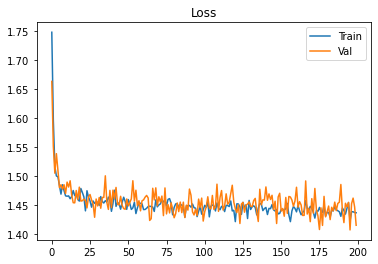

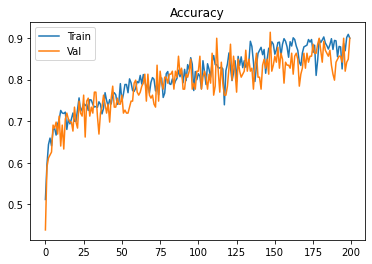

In [9]:
plt.figure(1)
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.title("Loss")
plt.legend(("Train", "Val"))

plt.figure(2)
plt.plot(epoch_train_accuracy)
plt.plot(epoch_val_accuracy)
plt.title("Accuracy")
plt.legend(("Train", "Val"))

In [10]:
max(epoch_val_accuracy)

tensor(0.9137, device='cuda:0')